In [20]:
import pickle
import time
import networkx as nx
import matplotlib.pyplot as plt
import osmnx as ox
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras.optimizer_v2.adam import Adam
from tensorflow.python.keras.optimizers import TFOptimizer
from tensorflow.python.keras.regularizers import l2
import config
import random
import numpy as np
# from dgl import DGLGraph
# from dgl.data import SBMMixture

import gnn.helpers.graph_generation_helper as helper
#from gnn.helpers.lgnn import LGNN

# pytorch
# import torch as th
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.utils.data import DataLoader

# from itertools import permutations

from timeit import timeit

from spektral.layers import GraphConv, GraphSageConv, GraphAttention
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout

In [12]:
# n_nodes % n_communities must = 0
#
# training_dataset = SBMMixture(n_graphs=10,
#                               n_nodes=3500,
#                               n_communities=25,
#                               avg_deg=3)

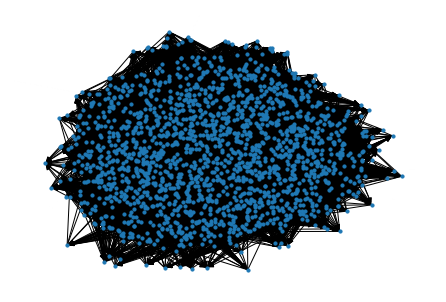

In [6]:
# g = training_dataset[0][1]
# nx.draw(g.to_networkx(), node_size=10)


In [2]:
# number of nodes in real graphs = 3245
# train:test = 80:20
partition_sizes = [random.randint(30, 60) for i in range(100)]
training_graph = nx.random_partition_graph(partition_sizes,
                              p_in=.1,
                              p_out=.01,
                              seed=10)
# test = nx.random_partition_graph(test_partition_sizes,
#                               p_in=.1,
#                               p_out=.01,
#                               seed=12)

4401 nodes - train
105682 edges - train


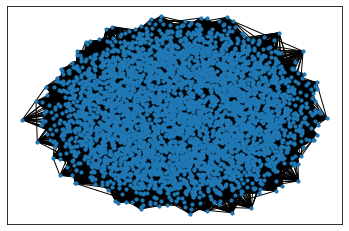

In [3]:
print(f"{training_graph.number_of_nodes()} nodes - train")
print(f"{training_graph.number_of_edges()} edges - train")
nx.draw_networkx(training_graph, with_labels=False, node_size=10)
#plt.draw()



In [7]:
A = nx.adjacency_matrix(training_graph, weight="weight")
# print(f"{test.number_of_nodes()} nodes - test")
# print(f"{test.number_of_edges()} edges - test")
# nx.draw_networkx(test, with_labels=False, node_size=10)

In [ ]:
#nx.write_gpickle(g, f"{config.gnn_path}/pickle/training_graph.gpickle")

In [ ]:
#g = nx.read_gpickle(f"{config.gnn_path}/pickle/training_graph.gpickle")

In [6]:
training_graph.size(weight="weight")

105682.0

In [8]:
# assign weight to all edges of train and test graphs
nx.set_edge_attributes(training_graph, 1, "weight")
helper.add_edge_weights_to_graph_partitions(training_graph, 7000)

Adding weights to partition 1
Partition 1 weights assigned
Adding weights to partition 2
Partition 2 weights assigned
Adding weights to partition 3
Partition 3 weights assigned
Adding weights to partition 4
Partition 4 weights assigned
Adding weights to partition 5
Partition 5 weights assigned
Adding weights to partition 6
Partition 6 weights assigned
Adding weights to partition 7
Partition 7 weights assigned
Adding weights to partition 8
Partition 8 weights assigned
Adding weights to partition 9
Partition 9 weights assigned
Adding weights to partition 10
Partition 10 weights assigned
Adding weights to partition 11
Partition 11 weights assigned
Adding weights to partition 12
Partition 12 weights assigned
Adding weights to partition 13
Partition 13 weights assigned
Adding weights to partition 14
Partition 14 weights assigned
Adding weights to partition 15
Partition 15 weights assigned
Adding weights to partition 16
Partition 16 weights assigned
Adding weights to partition 17
Partition 1

In [9]:
A_weighted = nx.adjacency_matrix(training_graph, weight="weight")

# nx.set_edge_attributes(test, 1, "weight")
# helper.add_edge_weights_to_graph_partitions(test, 10000)

In [ ]:
# # spread 10000 weight among edges in each partition
# partitions = g.graph["partition"]
# i = 1
# for p in partitions:
#     print(f"Labeling nodes in partition {i}")
#     for node in tuple(p):
#         attrs = {node: {"community": i}}
#         nx.set_node_attributes(g, attrs)
#     print(f"Partition {i} nodes are labelled")
#     print(f"Adding weights to partition {i}")
#     spread = 10000
#     while spread > 0:
#         n = random.randint(15, 200)
#         u = random.choice(tuple(p))
#         v = random.choice(tuple(p))
#         if g.has_edge(u, v) and (spread - n > 0):
#             weight_before = g[u][v]["weight"]
#             g[u][v]["weight"] = weight_before + n
#             spread = spread - n
#         elif spread - n < 0:
#             break
#     print(f"Partition {i} weights assigned"
#           f"\n===========================")
#     i += 1

In [12]:
training_graph.size(weight="weight")

795602.0

In [13]:
# pickle train/test graphs
nx.write_gpickle(training_graph, config.train_graph)
#nx.write_gpickle(test, config.test_graph)


In [2]:
train = nx.read_gpickle(config.train_graph)
#test = nx.read_gpickle(config.test_graph)
train

In [44]:
# from spektral.datasets import delaunay
# graph = delaunay.generate_data(classes=100, n_nodes=10000, return_type="networkx")

In [39]:
# from spektral.datasets import citation
# A, X, y, train_mask, val_mask, test_mask = citation.load_data('cora')

Loading cora dataset
Pre-processing node features


In [3]:
%%time

adjacency = nx.adjacency_matrix(train, weight="weight")
N = adjacency.shape[0]

node_labels = nx.get_node_attributes(train, "block")
# to array
labels_array = np.fromiter(node_labels.values(), dtype=int)

# create matrix representation of node community labels
n_values = np.max(labels_array) + 1
node_labels = np.eye(n_values)[labels_array]
# with open(f"{config.gnn_pickle_path}/labels_matrix.npy", "wb") as f:
#     np.save(f, node_labels)

# features
node_features = np.ones((N, 1))

CPU times: user 265 ms, sys: 11.8 ms, total: 276 ms
Wall time: 279 ms


NameError: name 'N' is not defined

In [21]:
%%time
# from https://github.com/danielegrattarola/spektral/blob/master/spektral/datasets/citation.py
# mask labels depending on which stage is being executed
def sample_mask(idx, l):
    mask = np.zeros(l)
    mask[idx] = 1
    return np.array(mask, dtype=np.bool)

from sklearn.model_selection import train_test_split
indices = np.arange(node_labels.shape[0])
n_classes = node_labels.shape[1]
# 80:20 train:test split
idx_train, idx_test, y_train, y_test = train_test_split(
    indices, node_labels, train_size=int(indices.shape[0] * 0.8), stratify=node_labels)
# take 10% as validation set
idx_val, idx_test, y_val, y_test = train_test_split(
    idx_test, y_test, train_size=int(idx_train.shape[0] * 0.1), stratify=y_test)

train_mask = sample_mask(idx_train, node_labels.shape[0])
val_mask = sample_mask(idx_val, node_labels.shape[0])
test_mask = sample_mask(idx_test, node_labels.shape[0])

CPU times: user 289 ms, sys: 3.2 ms, total: 292 ms
Wall time: 300 ms


In [23]:
%%time
# from https://graphneural.network/getting-started/#node-classification-on-citation-networks

F = node_features.shape[1]
#X_in = Input(shape=(F, ), sparse=True)
#A_in = Input((N, ), sparse=True)


# Parameters (https://github.com/danielegrattarola/spektral/blob/master/examples/node_prediction/citation_gcn.py)
channels = N           # Number of channels in the first layer
#N = X.shape[0]          # Number of nodes in the graph
#F = X.shape[1]          # Original size of node features
#n_classes = y.shape[1]  # Number of classes
dropout = 0.6           # Dropout rate for the features
#l2_reg = 5e-4 / 2       # L2 regularization rate
learning_rate = 1e-2    # Learning rate
epochs = 1000            # Number of training epochs
es_patience = 200        # Patience fot early stopping     # Patience for early stopping

# Model definition
X_in = Input(shape=(F, ))
fltr_in = Input((N, ), sparse=True)
#
# dropout_1 = Dropout(dropout)(X_in)
# graph_conv_1 = GraphConv(channels,
#                          activation='relu',
#                          kernel_regularizer=l2(l2_reg),
#                          use_bias=False)([dropout_1, fltr_in])
#
# dropout_2 = Dropout(dropout)(graph_conv_1)
# graph_conv_2 = GraphConv(n_classes,
#                          activation='softmax',
#                          use_bias=False)([dropout_2, fltr_in])

# # Build model
# model = Model(inputs=[X_in, fltr_in], outputs=graph_conv_2)
# optimizer = Adam(lr=learning_rate)
# model.compile(optimizer=optimizer,
#               loss='categorical_crossentropy',
#               weighted_metrics=['acc'])
# model.summary()

# https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

dropout_1 = Dropout(0.9)(X_in)
gs1 = GraphSageConv(int(N * 0.9), activation="relu")([dropout_1, fltr_in])
dropout_2 = Dropout(0.6)(dropout_1)
gs2 = GraphSageConv(int(N * 0.6), activation="relu")([dropout_2, fltr_in])


dropout_l = Dropout(dropout)(dropout_2)
gs_l = GraphSageConv(n_classes, activation="softmax")([dropout_l, fltr_in])

# Build model
model = Model(inputs=[X_in, fltr_in], outputs=gs_l)
#optimizer = Adam(lr=learning_rate) # https://keras.io/api/optimizers/adam/
optimizer = Adam(0.00001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['acc'])
model.summary()

# dropout_1 = Dropout(dropout)(X_in)
# X_1 = GraphConv(N, 'relu')([X_in, A_in])
# X_1 = Dropout(0.5)(X_1)
# X_2 = GraphConv(N, 'relu')([X_1, A_in])
# X_2 = Dropout(0.5)(X_2)
# X_3 = GraphConv(N, 'relu')([X_2, A_in])
# X_3 = Dropout(0.5)(X_3)
# X_L = GraphConv(n_classes, 'softmax')([X_3, A_in])
#
# model = Model(inputs=[X_in, A_in], outputs=tf.identity(X_L))

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
dropout_15 (Dropout)            (None, 1)            0           input_15[0][0]                   
__________________________________________________________________________________________________
dropout_16 (Dropout)            (None, 1)            0           dropout_15[0][0]                 
__________________________________________________________________________________________________
dropout_17 (Dropout)            (None, 1)            0           dropout_16[0][0]                 
____________________________________________________________________________________________

In [12]:
# %%time
# # f4 = float 4
# adj_preprocessed = GraphConv.preprocess(adjacency).astype("f4")
#
# #optimizer='adam'
# model.compile(optimizer="adam",
#               loss="categorical_crossentropy",
#               weighted_metrics=["acc"])
# model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 4401)]       0                                            
__________________________________________________________________________________________________
graph_conv_8 (GraphConv)        (None, 4401)         8802        input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 4401)         0           graph_conv_8[0][0]         

In [24]:
%%time
# Train model
fltr = GraphAttention.preprocess(adjacency).astype("f4")
validation_data = ([node_features, fltr], node_labels, val_mask)
model.fit([node_features, fltr], node_labels,
          sample_weight=train_mask,
          epochs=epochs,
          validation_data=validation_data,
          batch_size=N,
          shuffle=False,  # Shuffling data means shuffling the whole graph
          callbacks=[
              EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)
          ])


# validation_data = ([node_features, adj_preprocessed],
#                    node_labels, val_mask)
#
# # Train model
# model.fit([node_features, adj_preprocessed], node_labels,
#           sample_weight=train_mask,
#           validation_data=validation_data,
#           batch_size=N,
#           shuffle=False)

Epoch 1/1000
1/1 [==============================] - 0s 482ms/step - loss: 3.6850 - acc: 0.0109 - val_loss: 0.3687 - val_acc: 0.0075
Epoch 2/1000
1/1 [==============================] - 0s 349ms/step - loss: 3.6802 - acc: 0.0105 - val_loss: 0.3687 - val_acc: 0.0075
Epoch 3/1000
1/1 [==============================] - 0s 345ms/step - loss: 3.6799 - acc: 0.0132 - val_loss: 0.3687 - val_acc: 0.0075
Epoch 4/1000
1/1 [==============================] - 0s 324ms/step - loss: 3.6814 - acc: 0.0127 - val_loss: 0.3687 - val_acc: 0.0075
Epoch 5/1000
1/1 [==============================] - 0s 317ms/step - loss: 3.6810 - acc: 0.0136 - val_loss: 0.3687 - val_acc: 0.0075
Epoch 6/1000
1/1 [==============================] - 0s 324ms/step - loss: 3.6821 - acc: 0.0132 - val_loss: 0.3687 - val_acc: 0.0075
Epoch 7/1000
1/1

In [25]:
%%time
# Evaluate model
print('Evaluating model.')
eval_results = model.evaluate([node_features, fltr],
                              node_labels,
                              sample_weight=test_mask,
                              batch_size=N)
print('Done.\n'
      'Test loss: {}\n'
      'Test accuracy: {}'.format(*eval_results))

## Test accuracy: 0.013406043872237206

# # Evaluate model
# eval_results = model.evaluate([node_features, adj_preprocessed], node_labels,
#                               sample_weight=test_mask,
#                               batch_size=N)
# print('Done.\n'
#       'Test loss: {}\n'
#       'Test accuracy: {}'.format(*eval_results))


# https://graphneural.network/examples/


Evaluating model.
1/1 [==============================] - 0s 927us/step - loss: 0.5543 - acc: 0.0075
Done.
Test loss: 0.5542700886726379
Test accuracy: 0.0074982959777116776
CPU times: user 382 ms, sys: 9.81 ms, total: 391 ms
Wall time: 368 ms


In [ ]:
# convert networkx test/train graphs to dgl graphs,
# extract node and edge features.
dgl_train = DGLGraph()
dgl_train.from_networkx(train, edge_attrs=["weight"], node_attrs=["block"])

dgl_test = DGLGraph()
dgl_test.from_networkx(test, edge_attrs=["weight"], node_attrs=["block"])

# then create line graph
dgl_train_lg = dgl_train.line_graph(backtracking=False)

In [4]:
# from dgl.data import citation_graph as citegrh
# data = citegrh.load_cora()
# e = list(dgl_train.edges)

In [4]:
# create features and labels variables
features = dgl_train.edata["weight"]
labels = dgl_train.ndata["block"]
# mask = th.BoolTensor(data.train_mask)
# g = data.graph
lg_features = np.vstack(features)


mask_train = np.zeros(dgl_train.number_of_nodes())
mask_train = th.BoolTensor(mask_train)

In [4]:

print(f"{dgl_train.number_of_nodes()} nodes")
print(f"{dgl_train.number_of_edges()} edges")

7050 nodes
525498 edges


In [16]:
len(th.unique(labels))

160

In [19]:
# net = LGNN(g=dgl_train,
#            in_feats=features.shape[0],
#            hidden_size=21,
#            hidden_layers=2,
#            out_feats=len(th.unique(labels)),
#            dropout=0.1,
#            batchnorm=False,
#            lg=dgl_train_lg,
#            radius=2)
#
# # define the optimizer
# optimizer = th.optim.Adam(net.parameters(), lr=0.01, weight_decay=0.1)
#
# all_logits = []
# all_losses = []
# all_losses_val = []



In [20]:
# train
# for epoch in range(1000):
#
#     # # Compute loss for test nodes (only for validation, not used by optimizer)
#     # net.eval()
#     # prediction = F.log_softmax(net((features, lg_features)),1)
#     # val_loss = F.nll_loss(prediction.detach()[mask_val], labels[mask_val])
#     # all_losses_val.append(val_loss.item())
#     # val_acc = acc(labels[mask_val],prediction.detach()[mask_val].numpy().argmax(axis=1))
#     # net.train()
#
#     logits = net((features, lg_features))
#     # Save logits for visualization later
#     all_logits.append(logits.detach())
#     logp = F.log_softmax(logits, 1)
#
#     # Compute loss for train nodes
#     loss = F.nll_loss(logp[mask_train], labels[mask_train])
#     all_losses.append(loss.detach().item())
#
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
#
#     #print('Epoch %d | Loss: %.4f | Total: %.4f | Acc: %.4f' % (epoch, loss.item(), val_loss.item(),val_acc))
#     print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))



DGLError: Expect number of features to match number of nodes (len(u)). Got 525498 and 7050 instead.

In [ ]:
# training_loader = DataLoader(train)

In [ ]:
# K = len(train.graph["partition"])
# device = th.device("cpu")

In [ ]:
# ones = th.ones(dgl_train.number_of_nodes() // K)
# permutations = list(permutations(range(K)))

In [ ]:
# y_list = [th.cat([x * ones
#                   for x in p]).long().to(device)
#           for p in permutations(range(K))]
#

In [5]:
K = len(train.graph["partition"])
device = th.device("cpu")
n_layers = 1
radius = 1
feats = [1] + [len(features)] * n_layers + [K]
model = LGNN(feats, radius, K).to(device)
# define the optimizer
optimizer = th.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.1)

In [ ]:
# # train
# for epoch in range(1000):
#
#     # Compute loss for test nodes (only for validation, not used by optimizer)
#     model.eval()
#     prediction = F.log_softmax(net((g_feat, lg_feat)),1)
#     val_loss = F.nll_loss(prediction.detach()[mask_val], labels[mask_val])
#     all_losses_val.append(val_loss.item())
#     val_acc = acc(labels[mask_val],prediction.detach()[mask_val].numpy().argmax(axis=1))
#     net.train()
#
#     logits = net((g_feat, lg_feat))
#     # Save logits for visualization later
#     all_logits.append(logits.detach())
#     logp = F.log_softmax(logits, 1)
#
#     # Compute loss for train nodes
#     loss = F.nll_loss(logp[mask_train], labels[mask_train])
#     all_losses.append(loss.detach().item())
#
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
#
#     print('Epoch %d | Loss: %.4f | Total: %.4f | Acc: %.4f' % (epoch, loss.item(), val_loss.item(),val_acc))
#

In [6]:
deg_g = dgl_train.in_degrees().float().unsqueeze(1)
deg_lg = dgl_train_lg.in_degrees().float().unsqueeze(1)
pm_pd = list(zip(*[dgl_train.edges()]))[0][0]
#pm_pd = th.tensor(pm_pd)

In [ ]:
ones = th.ones(len(dgl_train.nodes) // K)
y_list = [th.cat([x * ones for x in p]).long().to(device) for p in permutations(range(K))]

In [ ]:
#training_loader = DataLoader(train)

# def from_np(f, *args):
#     def wrap(*args):
#         new = [th.from_numpy(x) if isinstance(x, np.ndarray) else x for x in args]
#         return f(*new)
#     return wrap
#
# @from_np
# def step(i, j, g, lg, deg_g, deg_lg, pm_pd):
#     """ One step of training. """
#     deg_g = deg_g.to(th.device("cpu"))
#     deg_lg = deg_lg.to(th.device("cpu"))
#     pm_pd = pm_pd.to(th.device("cpu"))
#     t0 = time.time()
#     z = model(g, lg, deg_g, deg_lg, pm_pd)
#     t_forward = time.time() - t0
#
#     z_list = th.chunk(z, 1, 0)
#     loss = sum(min(F.cross_entropy(z, y) for y in y_list) for z in z_list)
#     #overlap = compute_overlap(z_list)
#
#     optimizer.zero_grad()
#     t0 = time.time()
#     loss.backward()
#     t_backward = time.time() - t0
#     optimizer.step()
#
#     return loss, t_forward, t_backward

# n_iterations = args.n_graphs // args.batch_size
n_epochs = 1000
for i in range(n_epochs):
    total_loss, total_overlap, s_forward, s_backward = 0, 0, 0, 0
    total_loss, s_forward, s_backward = 0, 0, 0

    # for j, [g, lg, deg_g, deg_lg, pm_pd] in enumerate(training_loader):
    #     loss, t_forward, t_backward = step(i, j, g, lg, deg_g, deg_lg, pm_pd)
    #
    #     total_loss += loss
    #     #total_overlap += overlap
    #     s_forward += t_forward
    #     s_backward += t_backward
    #
    #     epoch = '0' * (len(str(n_epochs)) - len(str(i)))
    #     print('[epoch %s%d]loss %.3f'
    #               % (epoch, i, loss))

    deg_g = deg_g.to(device)
    deg_lg = deg_lg.to(device)
    pm_pd = pm_pd.to(device)
    t0 = time.time()
    z = model(dgl_train, dgl_train_lg, deg_g, deg_lg, pm_pd)

    t_forward = time.time() - t0

    total_loss += loss
    #total_overlap += overlap
    s_forward += t_forward
    s_backward += t_backward

    z_list = th.chunk(z, 1, 0)
    loss = sum(min(F.cross_entropy(z, y) for y in y_list) for z in z_list)
    #overlap = compute_overlap(z_list)

    optimizer.zero_grad()
    t0 = time.time()
    loss.backward()
    t_backward = time.time() - t0
    optimizer.step()

##############
    # epoch = '0' * (len(str(n_epochs)) - len(str(i)))
    # loss = total_loss / (j + 1)
    # overlap = total_overlap / (j + 1)
    # t_forward = s_forward / (j + 1)
    # t_backward = s_backward / (j + 1)
    # print('[epoch %s%d]loss %.3f | overlap %.3f | forward time %.3fs | backward time %.3fs'
    #       % (epoch, i, loss, overlap, t_forward, t_backward))

    # overlap_list = test()
    # overlap_str = ' - '.join(['%.3f' % overlap for overlap in overlap_list])
    # print('[epoch %s%d]overlap: %s' % (epoch, i, overlap_str))
